In [ ]:
[{
    "image_path": "20240101_174237.jpg",
    "output": "The image is funny because it depicts a pink man standing on a traffic light, and it's a reference to the famous \"Pink Man\" painting by Banksy. The image also has a humorous twist, as the pink man is wearing a red shirt, which is a common sight in street art. The juxtaposition of the man standing on a traffic signal and wearing a red t-shirt creates a humorous and unexpected visual."
  }]

In [1]:
import sys

# Add your custom path
custom_path = "../LLaVA"
sys.path.append(custom_path)

In [2]:
from transformers import AutoTokenizer, BitsAndBytesConfig
from llava.model import LlavaLlamaForCausalLM
import torch

model_path = "4bit/llava-v1.5-13b-3GB"
kwargs = {"device_map": "auto"}
kwargs['load_in_4bit'] = True
kwargs['quantization_config'] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4'
)
model = LlavaLlamaForCausalLM.from_pretrained(model_path, low_cpu_mem_usage=True, **kwargs)
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)

vision_tower = model.get_vision_tower()
if not vision_tower.is_loaded:
    vision_tower.load_model()
vision_tower.to(device='cuda')
image_processor = vision_tower.image_processor

[2024-05-25 20:07:29,789] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
# import os
# def to_dalle_path(type, og_filename, side):
#     return os.path.join(f"outputs/dalle3/{type.lower()}/{side.lower()}",f"{og_filename}_{type}_{side}.jpg")

# def get_lr_path_from_filename(filename):
#     if not "YES" in filename and not "BUT" in filename:
#         yes = os.path.join("images_split",f"{filename[:-4]}_YES.jpg")
#         but = os.path.join("images_split",f"{filename[:-4]}_BUT.jpg")
#     else:
#         parts = filename.split("_")
#         #print(parts)
#         og_filename = "_".join(parts[:-4])
#         yestype, buttype = parts[-4], parts[-2]
#         yes = to_dalle_path(yestype, og_filename, "YES") if yestype!="ORIG" else os.path.join("images_split",f"{og_filename}_YES.jpg")
#         but = to_dalle_path(buttype, og_filename, "BUT") if buttype!="ORIG" else os.path.join("images_split",f"{og_filename}_BUT.jpg")
#     return yes,but

# print(get_lr_path_from_filename("20240101_172315_STICK_YES_3D_BUT.jpg"))

In [4]:
from PIL import Image

# def join_images(images):
#     max_width = max(img.width for img in images)
#     total_height = max(img.height for img in images)
#     padding = int(0.05 * max_width)
#     new_image = Image.new('RGB', (len(images) * max_width + (len(images)-1) * padding, total_height), (255, 255, 255))
#     current_width = 0
#     for img in images:
#         new_image.paste(img, (current_width, 0))
#         current_width += img.width + padding
#     return new_image

# l,r = get_lr_path_from_filename("20240101_172315_3D_YES_3D_BUT.jpg")
# image = join_images([Image.open(l), Image.open(r)])
# display(image.resize((336,336)))

In [ ]:
import os
import requests
from io import BytesIO
from llava.conversation import conv_templates, SeparatorStyle
from llava.utils import disable_torch_init
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.mm_utils import tokenizer_image_token, get_model_name_from_path, KeywordsStoppingCriteria
from transformers import TextStreamer

def caption_image(image, prompt):
    disable_torch_init()
    conv_mode = "llava_v0"
    conv = conv_templates[conv_mode].copy()
    roles = conv.roles
    image_tensor = image_processor.preprocess(image, return_tensors='pt')['pixel_values'].half().cuda()
    inp = f"{roles[0]}: {prompt}"
    inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + inp
    conv.append_message(conv.roles[0], inp)
    conv.append_message(conv.roles[1], None)
    raw_prompt = conv.get_prompt()
    input_ids = tokenizer_image_token(raw_prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()
    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)
    with torch.inference_mode():
      output_ids = model.generate(input_ids, images=image_tensor, do_sample=True, temperature=0.9, top_p=0.6,
                                  max_new_tokens=128, use_cache=True, stopping_criteria=[stopping_criteria])
    outputs = tokenizer.decode(output_ids[0, input_ids.shape[1]:]).strip()
    conv.messages[-1][-1] = outputs
    output = outputs.rsplit('</s>', 1)[0]
    return image, output

image = Image.open("yesbut_second_round_negatives/20240101_172339_STICK_YES_STICK_BUT.jpg")
image, output = caption_image(image, "Describe this image")
display(image.resize((336,336)))
print(output)

PROMPT:  A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions.###Human: <im_start><image><im_end>
Human: Why is this image funny/satirical? Explain in about 50-70 words###Assistant:
The image is funny and satirical because the Google search bar shows that the user is searching for information about bitcoins and earning money from them. This is amusing because it is a playful representation of people's obsession with making money, especially through digital means. Furthermore, the image suggests that the user might be looking for ways to use their iPhone to generate extra income, which adds to the humor of the situation, as it seems like an implausible solution. The contrast between the user's expectations and the actual results, combined with the exaggerated nature of the search results, creates a comical and lighthearted effect.


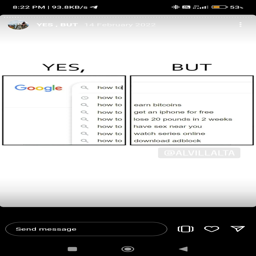

In [9]:
import os
import requests
from io import BytesIO
from llava.conversation import conv_templates, SeparatorStyle
from llava.utils import disable_torch_init
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.mm_utils import tokenizer_image_token, get_model_name_from_path, KeywordsStoppingCriteria
from transformers import TextStreamer

def caption_image(image, prompt, verbose=False, cot=False):
    image = image.convert('RGB')
    disable_torch_init()
    conv_mode = "llava_v0"
    conv = conv_templates[conv_mode].copy()
    roles = conv.roles
    image_tensor = image_processor.preprocess(image, return_tensors='pt')['pixel_values'].half().cuda()
    inp = f"{roles[0]}: {prompt}"
    labels = ["Y", "N"]
    inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + inp
    conv.append_message(conv.roles[0], inp)
    conv.append_message(conv.roles[1], None)
    raw_prompt = conv.get_prompt()
    if cot:
        raw_prompt+="Lets think step by step. This image has 2 halves - they depict "
        max_new_tokens = 1024
    else:
        #raw_prompt+=" ["
        max_new_tokens = 256
        
    if verbose:
        print("PROMPT: ",raw_prompt)
    input_ids = tokenizer_image_token(raw_prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()
    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)
    with torch.inference_mode():
      output_ids = model.generate(input_ids, images=image_tensor, do_sample=True, temperature=0.7,
                                  max_new_tokens=max_new_tokens, use_cache=True, stopping_criteria=[stopping_criteria])
    outputs = tokenizer.decode(output_ids[0, input_ids.shape[1]:]).strip()
    conv.messages[-1][-1] = outputs
    output0 = outputs.rsplit('</s>', 1)[0]

    input_ids.to("cpu")
    del input_ids
    output_ids.to("cpu")
    del output_ids

    output = None
    if cot:
        if verbose:
            print(output0)
        raw_prompt+=output0+". Hence the correct option out of Y/N is ["

        input_ids = tokenizer_image_token(raw_prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()
        stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
        keywords = [stop_str]
        stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)
        with torch.inference_mode():
          output_ids = model.generate(input_ids, images=image_tensor, do_sample=True, temperature=0.2,
                                      max_new_tokens=8, use_cache=True, stopping_criteria=[stopping_criteria])
        outputs = tokenizer.decode(output_ids[0, input_ids.shape[1]:]).strip()
        conv.messages[-1][-1] = outputs
        output = outputs.rsplit('</s>', 1)[0]

        input_ids.to("cpu")
        del input_ids
        output_ids.to("cpu")
        del output_ids

    image_tensor.to("cpu")
    del image_tensor
    
    return image, output0, output

prompt = '''You are an AI expert in detecting humour or satire. User gives you an image, and you have to make a choice "Y" or "N".
###Instructions: The image contains 2 halves - left (called yes) and right (called but). The images in both might be related and have a funny overall meaning, or they may make no sense. Make a choice "Y" if the combined image is funny or "N" if its not funny:
###Output format: one character, only one of [Y] or [N]'''
prompt = "Why is this image funny/satirical? Explain in about 50-70 words"
image, output0, output = caption_image(Image.open("images_real/Screenshot_2024-05-23-20-22-16-966_com.instagram.android.jpg"), prompt, True, False)
print(output0)
display(image.resize((256,256)))

In [13]:
import os,json
from tqdm import tqdm
#from validate import validate_file
import random

outpath = "outputs/annotations/images_real/whyfunny/llava-whyfunny.json"
inpaths = ["images_real"]

try:
    with open(outpath, "r") as f:
        outputs = json.load(f)
except FileNotFoundError:
    print("starting from zero")
    outputs = {}
    
    
total, correct, adhering = 0,0,0
files = sum(([os.path.join(folder, file) for file in os.listdir(folder)] for folder in inpaths),[])   
random.shuffle(files)
pbar = tqdm(files)
for filepath in pbar:
    folder, file = filepath.split("/")
    if filepath in outputs and outputs[filepath]:
        total+=1
        #correct+= 1 if ((outputs[filepath]["pred"][0]=="Y" and "negative" not in folder) or (outputs[filepath]["pred"][0]=="N" and "negative" in folder)) else 0
        #adhering+= 1 if outputs[filepath]["pred"][0] in ["Y", "N"] else 0
        pbar.set_postfix({"folder": folder, "total": total, "accuracy": correct/total, "adherance": adhering/total})
        continue
    image = Image.open(filepath)
    _, reason, pred = caption_image(image, prompt, verbose=False, cot=False)
    #output = {"reason":reason, "pred": pred}
    output = reason
    
    outputs[filepath]= output
    with open(outpath, "w") as f:
        json.dump(outputs, f, indent=4)

    total+=1
    #correct+= 1 if ((output["pred"][0]=="Y" and "negative" not in folder) or (output["pred"][0]=="N" and "negative" in folder)) else 0
    #adhering+= 1 if output["pred"][0] in ["Y", "N"] else 0
    pbar.set_postfix({"folder": folder, "total": total, "accuracy": correct/total, "adherance": adhering/total})
with open(outpath, "w") as f:
    json.dump(outputs, f, indent=4)
# if not validate_file(outpath):
#     print("Validation failed!")                           

100%|█████████████████████████████████████████████████| 119/119 [10:07<00:00,  5.11s/it, folder=images_real, total=119, accuracy=0, adherance=0]


In [ ]:
with open("llava-13b-4bit-zeroshot.json", "w") as f:
    json.dump(outputs, f, indent=2)                           

In [ ]:
for filename in os.listdir("images")[:10]:
    display(Image.open(os.path.join("images",filename)).convert('RGB'))
    for o in outputs:
        if  o["image_path"] == filename:
            print(o["output"])

In [ ]:
import csv

with open("random.csv", 'w', newline='') as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=['filename'])
    writer.writeheader()
    for filename in os.listdir("images"):
        writer.writerow({'filename': filename})